## using yt's stretched grid functionality with zfp-compressed lofs-cm1 netcdf files

yt 4.1.0 includes improved handling of stretched grids (defined as grids with variable spacing in each dimension). Stretched grids are common in geoscience data and so it's useful to demonstrate in the context of the zfp-compressed lofs-cm1 netcdf files (see zfp_cm1_yt_demo.ipynb in this repository). 



In [19]:
import h5py 
import yt 
import hdf5plugin
from yt.sample_data.api import lookup_on_disk_data
import numpy as np


def get_widths(coord):
    # calculates the cell width from an array of observation points, preserving
    # the min/max of the ranges. 
    extrema = [coord.min(), coord.max()]
    
    # calculate edges of cells, preserving data min/max.
    edges = (coord[1:] +coord[0:-1])/2
    edges = np.concatenate([np.array([extrema[0]]), edges, np.array([extrema[1]])])                        
    wids = edges[1:] - edges[0:-1]
    return wids.astype(np.float64), extrema, edges
    
def load_cm1_stretched_in_memory(fn, fields = None):
    """ loads lofs-cm1 data on a single stretched grid """
    
    data_coords = ("zh", "yh", "xh")  # name in the netcdf file 
    yt_coord_name = ("z", "y", "x")  # internal yt name
    
    if fields is None:
        fields = ["dbz", "vortmag"]
        
    # first read in the data and global coordinates
    fn = str(lookup_on_disk_data(fn))
    data = {}    
    global_coord_info = {}  # store the x,y,z widths and ranges across the dataset
    with h5py.File(fn, "r") as handle:
        for dim, ytdim in zip(data_coords, yt_coord_name):
            global_coord_info[ytdim] = get_widths(handle[dim][:])
            
        for field in fields:
            data[field] = (handle[field][0,:], "")  # neglecting units here 
            
    
    # store the bounding box
    bbox = np.array([global_coord_info[dim][1] for dim in yt_coord_name])
    
    # store the cell widths
    cell_wids = [global_coord_info[dim][0] for dim in yt_coord_name]

    return yt.load_uniform_grid(data, data[fields[0]][0].shape, 
                                length_unit="km", 
                                geometry=("cartesian", yt_coord_name),
                                bbox=bbox, 
                                cell_widths=cell_wids)

In [20]:
ds = load_cm1_stretched_in_memory("cm1_zfp_compressed/mkow075-ens-db620.00790800.nc")

yt : [INFO     ] 2022-10-05 11:11:03,047 Parameters: current_time              = 0.0
yt : [INFO     ] 2022-10-05 11:11:03,048 Parameters: domain_dimensions         = [ 232  996 1096]
yt : [INFO     ] 2022-10-05 11:11:03,050 Parameters: domain_left_edge          = [  0.0375     -29.88750076 -37.38750076]
yt : [INFO     ] 2022-10-05 11:11:03,052 Parameters: domain_right_edge         = [17.36249924 44.73749924 44.73749924]
yt : [INFO     ] 2022-10-05 11:11:03,053 Parameters: cosmological_simulation   = 0


yt : [INFO     ] 2022-10-05 11:11:05,182 xlim = -37.387501 44.737499
yt : [INFO     ] 2022-10-05 11:11:05,183 ylim = -29.887501 44.737499
yt : [INFO     ] 2022-10-05 11:11:05,184 xlim = -37.387501 44.737499
yt : [INFO     ] 2022-10-05 11:11:05,185 ylim = -29.887501 44.737499
yt : [INFO     ] 2022-10-05 11:11:05,193 Making a fixed resolution buffer of (('stream', 'dbz')) 800 by 800



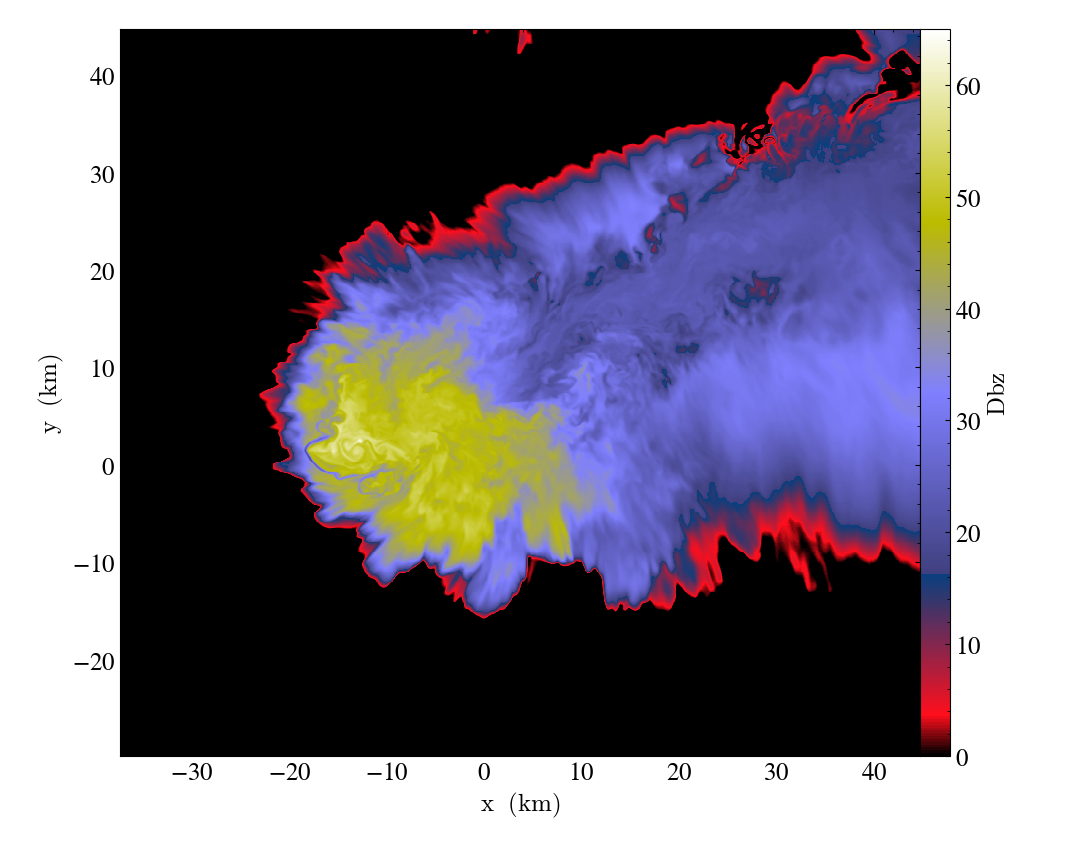

In [21]:
def set_cmap_prefs(yt_plot, field, cmap_name, cmap_limits):
    yt_plot.set_log(field, False)
    yt_plot.set_cmap(field, cmap_name)
    yt_plot.set_zlim(field, cmap_limits[0], cmap_limits[1])
    
field = ("stream", "dbz")
slc = yt.SlicePlot(ds, "z", field, origin="native")
set_cmap_prefs(slc, field, "gist_stern", (0., 65.))
slc.show()